In [3]:
from keras.applications import VGG16

In [4]:
conv_base = VGG16(weights='imagenet', 
                    include_top=False, 
                    input_shape=(150,150,3))

- `weights` specifies the weight checkpoint from which to initialize the model.   
- `include_top` refers to including (or not) the densely connected classifier on top of the network. By default, this densely connected classifier corresponds to the 1,000 classes from ImageNet. Because you intend to use your own densely connected classifier (with only two classes: cat and dog), you don’t need to include it.   
- `input_shape` is the shape of the image tensors that you’ll feed to the network. This argument is purely optional: if you don’t pass it, the network will be able to process inputs of any size.

In [5]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

# Fast Feature Extraction Without Data Augmentation

In [7]:
import os 
import numpy as np 
from keras.preprocessing.image import ImageDataGenerator 

base_dir = 'Data/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale = 1./255)
batch_size = 20 

In [10]:
def extract_features(directory, sample_count):
    features = np.zeros(shape = (sample_count, 4, 4, 512))
    labels = np.zeros(shape = (sample_count))
    generator = datagen.flow_from_directory(
        directory, 
        target_size = (150,150),
        batch_size = batch_size, 
        class_mode = 'binary'
    )
    i = 0 
    for inputs_batch, labels_batch in generator: 
        features_batch = conv_base.predict(inputs_batch)
        features[i*batch_size: (i+1)*batch_size] = features_batch
        labels[i*batch_size: (i+1)*batch_size] = labels_batch 
        i += 1 
        if i*batch_size >= sample_count:
            break 
    return features, labels 


train_features, train_labels = extract_features(train_dir, 2000)
valid_features, valid_labels = extract_features(valid_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)


Found 2000 images belonging to 2 classes.
1/1 [==============================] - 1s 648ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 1s 685ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 1s 821ms/step


In [16]:
train_features = np.reshape(train_features, (2000, 4*4*512))
valid_features = np.reshape(valid_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))

## Model Training

In [17]:
from keras import models 
from keras import layers
from keras import optimizers 

model = models.Sequential()
model.add(layers.Dense(256, activation = 'relu', input_dim = 4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer = optimizers.RMSprop(learning_rate=2e-5),
            loss = 'binary_crossentropy', 
            metrics = ['acc'])

history = model.fit(train_features, train_labels, 
                    epochs = 30, 
                    batch_size = 20, 
                    validation_data = (valid_features, valid_labels))

Epoch 1/30
100/100 [==============================] - 2s 14ms/step - loss: 0.6815 - acc: 0.7665 - val_loss: 0.2774 - val_acc: 0.8930
Epoch 2/30
100/100 [==============================] - 2s 16ms/step - loss: 0.3504 - acc: 0.8520 - val_loss: 0.2547 - val_acc: 0.8990
Epoch 3/30
100/100 [==============================] - 2s 16ms/step - loss: 0.2880 - acc: 0.8810 - val_loss: 0.3023 - val_acc: 0.8740
Epoch 4/30
100/100 [==============================] - 2s 16ms/step - loss: 0.2252 - acc: 0.9040 - val_loss: 0.2528 - val_acc: 0.8940
Epoch 5/30
100/100 [==============================] - 2s 16ms/step - loss: 0.2221 - acc: 0.9145 - val_loss: 0.3644 - val_acc: 0.8480
Epoch 6/30
100/100 [==============================] - 2s 16ms/step - loss: 0.1754 - acc: 0.9350 - val_loss: 0.2642 - val_acc: 0.9010
Epoch 7/30
100/100 [==============================] - 2s 16ms/step - loss: 0.1600 - acc: 0.9400 - val_loss: 0.3136 - val_acc: 0.8790
Epoch 8/30
100/100 [==============================] - 2s 15ms/step - 

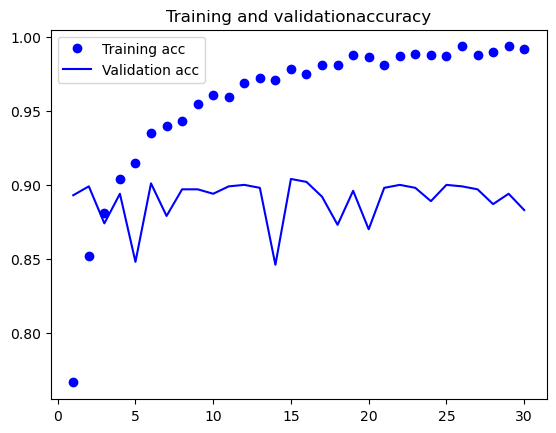

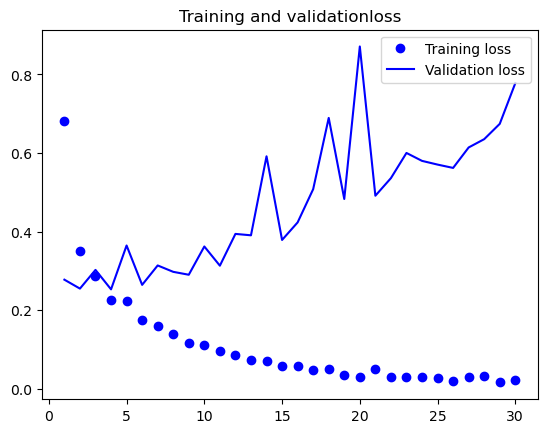

In [19]:
# Model Eval 
import matplotlib.pyplot as plt
acc = history.history['acc'] 
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss'] 

epochs=range(1,len(acc)+1) 

plt.plot(epochs,acc,'bo',label='Training acc') 
plt.plot(epochs,val_acc,'b',label='Validation acc') 
plt.title('Training and validationaccuracy') 
plt.legend() 
plt.figure() 

plt.plot(epochs,loss,'bo',label='Training loss') 
plt.plot(epochs,val_loss,'b',label='Validation loss') 
plt.title('Training and validationloss') 
plt.legend() 
plt.show()

# Feature Extraction with Data Augmentation  

Run only on GPU as it is very computationally expensive

In [21]:
from keras import models 
from keras import layers 

model = models.Sequential() 
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               2097408   
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 16812353 (64.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
conv_base.trainable = False

In [23]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
            rescale = 1./255,
            rotation_range = 40, 
            width_shift_range = 0.2, 
            height_shift_range = 0.2, 
            shear_range = 0.2, 
            zoom_range = 0.2,
            horizontal_flip = True, 
            fill_mode = 'nearest'
)
valid_datagen = ImageDataGenerator(rescale = 1./255)

In [24]:
train_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size = (150,150),
        batch_size = 20, 
        class_mode = 'binary'
    )

valid_generator = valid_datagen.flow_from_directory(
        valid_dir, 
        target_size = (150,150),
        batch_size = 20, 
        class_mode = 'binary'
    )

model.compile(loss = 'binary_crossentropy',
            optimizer = optimizers.RMSprop(learning_rate = 2e-5), 
            metrics = ['acc'])

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
history = model.fit_generator(
    train_generator, 
    steps_per_epoch = 100, 
    epochs = 30, 
    validation_data = validation_generator, 
    validation_steps = 50
)

# Finetuning

In [25]:
conv_base.trainable = True

set_trainable = False 
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable == True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model.compile(loss = 'binary_crossentropy',
            optimizer = optimizers.RMSprop(learning_rate = 1e-5), 
            metrics = ['acc'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch = 100, 
    epochs = 100, 
    validation_data = validation_generator, 
    validation_steps = 50
)

In [ ]:
# Smooth the accuracy and loss plots 

def smooth_curve(points,factor=0.8): 
    smoothed_points =[] 
    for point in points: 
        if smoothed_points: 
            previous = smoothed_points[-1] 
            smoothed_points.append(previous*factor + point*(1-factor)) 
            else: 
                smoothed_points.append(point) 
    return smoothed_points 


plt.plot(epochs, smooth_curve(acc),'bo',label='Smoothed training acc') 
plt.plot(epochs, smooth_curve(val_acc),'b',label='Smoothed validation acc') 
plt.title('Training and validation accuracy') 
plt.legend() 

plt.figure() 
plt.plot(epochs, smooth_curve(loss),'bo', label='Smoothed training loss') 
plt.plot(epochs, smooth_curve(val_loss),'b',label='Smoothed validation loss') 
plt.title('Training and validation loss') 
plt.legend() 
plt.show()